In [1]:
import os
import pandas as pd
import torch
import numpy as np
import pickle

def cmp_to_key(mycmp):
    'Convert a cmp= function into a key= function'
    class K(object):
        def __init__(self, obj, *args):
            self.obj = obj
        def __lt__(self, other):
            return mycmp(self.obj, other.obj) < 0
        def __gt__(self, other):
            return mycmp(self.obj, other.obj) > 0
        def __eq__(self, other):
            return mycmp(self.obj, other.obj) == 0
        def __le__(self, other):
            return mycmp(self.obj, other.obj) <= 0
        def __ge__(self, other):
            return mycmp(self.obj, other.obj) >= 0
        def __ne__(self, other):
            return mycmp(self.obj, other.obj) != 0
    return K

def compare(a,b):
    tmp1 = int(a[:-4])
    tmp2 = int(b[:-4])
    return tmp1 - tmp2

def get_partition(df, num_of_steps, num_of_classes, end_time = None):
    if end_time == None:
        end_time = df['time'][len(df['time'])-1]
    res = torch.zeros(num_of_steps, num_of_classes + 1)
    dt = end_time/num_of_steps
    res[:,0] = end_time/num_of_steps
    for i in range(len(df['time'])):
        k = int(df['time'][i]/dt)
        if k == num_of_steps:
            k-=1
        res[k,int(df['event'][i])+1] += 1
    return res

def get_dataset(path_to_files, n_classes, n_steps):
    files = os.listdir(path_to_files)
    target = None
    if 'clusters.csv' in files:
        files.remove('clusters.csv')
        target = torch.Tensor(pd.read_csv(path_to_files+'/clusters.csv')['cluster_id'])
    #print(target)
    files = sorted(files, key = cmp_to_key(compare))
    data = torch.zeros(len(files), n_steps, n_classes + 1)
    for i, f in enumerate(files):
        df = pd.read_csv(path_to_files+'/'+f)
        data[i,:,:] = get_partition(df, n_steps, n_classes)
    return data, target

path_to_files = 'data/simulated_Hawkes/K4_C5'
N_STEPS = 512
N_CLUSTERS = 4
EPS = 0.5
n_runs = 5

data, target = get_dataset(path_to_files, 5, N_STEPS)

#with open('utils/data.pkl', 'rb') as f:
#    data = pickle.load(f)
#    
#with open('utils/clusters.pkl', 'rb') as f:
#    target = pickle.load(f)
indices = np.random.permutation(data.shape[0])
data_train, target_train = data[indices[:9*data.shape[0]//10]],\
                           target[indices[:9*data.shape[0]//10]]
data_test, target_test = data[indices[9*data.shape[0]//10:]],\
                           target[indices[9*data.shape[0]//10:]]

import torch
from models.models import LSTM_cluster_point_processes
from utils.trainers import Trainer_clusterwise

device = 'cuda:0'

all_purs = []
all_purs_val = []
i = 0
#while i<n_runs:
test_param = [1.0001,1.0002,1.0003,1.0004,1.0005,1.0007,1.001]
#success = []
for i in test_param:
    #print('Run {}/{}'.format(i+1, n_runs))
    print('alpha =', i)
    model = LSTM_cluster_point_processes(6,128, 3, 5, 4, N_STEPS, dropout = 0.3).to(device)
    #model.load_state_dict(torch.load('reserv.pt'))
    optimizer = torch.optim.Adam(model.parameters(), lr =0.1, weight_decay = 1e-5)
    trainer = Trainer_clusterwise(model, optimizer, device, data, data_test,\
                              target, target_test, 4, alpha = i, beta = 0.001,\
                              epsilon = 1e-5, l = 30, eps = 0.0/N_CLUSTERS,\
                              max_epochs = 25, max_m_step_epochs = 50,\
                              lr_update_tol = 25, lr_update_param = 0.95,\
                             batch_size = 150)

    losses, purs, purs_val, cluster_part = trainer.train()
    if cluster_part == None:
        continue
    if cluster_part < EPS/N_CLUSTERS:
        print("Degenerate solution")
        #continue
    if losses:
        all_purs+=purs
        all_purs_val += purs_val
        i+=1


alpha = 1.0001
Beginning e-step
tensor(1600., device='cuda:0')
Cluster partition
Cluster 0 :  0.876875  with pi =  tensor(0.2500, device='cuda:0')
Cluster 1 :  0.039375  with pi =  tensor(0.2500, device='cuda:0')
Cluster 2 :  0.053125  with pi =  tensor(0.2500, device='cuda:0')
Cluster 3 :  0.030625  with pi =  tensor(0.2500, device='cuda:0')
Purity for random model: 0.27625
Beginning m-step
Entropy value: tensor(-3118.6221, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-3118.6797, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-3118.7412, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/50: 48253.31875
Loss on sub_epoch 11/50: 31228.2546875
Loss on sub_epoch 21/50: 31200.171875
Loss on sub_epoch 31/50: 31194.4654296875
Loss on sub_epoch 41/50: 31229.64140625
Entropy value: tensor(-5897.7393, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-5686.9272, device='cuda:0', grad_fn=<MulBackward0>) Fails
Clust

Validation loss = 32773.80859375, purity = 0.40625
Beginning e-step
tensor(1600., device='cuda:0')
Beginning m-step
Loss on sub_epoch 1/50: 30802.0771484375
Entropy value: tensor(-5853.2856, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-6018.4121, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-5922.6768, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/50: 30884.07578125
Updating lr
Loss on sub_epoch 21/50: 30888.3125
Entropy value: tensor(-5923.0601, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 31/50: 30810.2943359375
Loss on sub_epoch 41/50: 30940.120703125
Cluster partition
Cluster 0 :  0.223125  with pi =  tensor(0.2500, device='cuda:0')
Cluster 1 :  0.38875  with pi =  tensor(0.2500, device='cuda:0')
Cluster 2 :  0.136875  with pi =  tensor(0.2500, device='cuda:0')
Cluster 3 :  0.25125  with pi =  tensor(0.2500, device='cuda:0')
On epoch 6/25 average loss = 30931.2346796875, purity = 0.39625
Vali

Validation loss = 33032.26171875, purity = 0.41250000000000003
Beginning e-step
tensor(1600., device='cuda:0')
Beginning m-step
Loss on sub_epoch 1/50: 31040.304296875
Loss on sub_epoch 11/50: 30896.1275390625
Entropy value: tensor(-5809.7700, device='cuda:0', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-6182.3774, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-6210.7969, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-6050.7642, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-6110.8687, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-6153.8589, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-6117.8584, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-5997.4990, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/50: 30912.2005859375
Loss on sub_epoch 31/50: 31133.075390625
Loss on sub_epoch 41/50: 31004.805078125
Cluste

KeyboardInterrupt: 

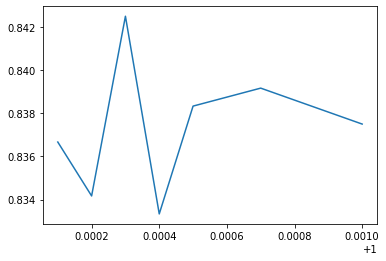

In [2]:
import numpy as np
import matplotlib.pyplot as plt
a = np.array(all_purs)
x = np.array(test_param)
plt.plot(x,a[24::25,1])

In [3]:
a[24::25]

array([[3.43671258e+04, 8.36666667e-01, 3.29166667e-01],
       [3.44131438e+04, 8.34166667e-01, 3.20000000e-01],
       [3.44577625e+04, 8.42500000e-01, 3.00000000e-01],
       [3.45422430e+04, 8.33333333e-01, 3.22500000e-01],
       [3.41757816e+04, 8.38333333e-01, 3.31666667e-01],
       [3.46507414e+04, 8.39166667e-01, 3.30833333e-01],
       [3.39208500e+04, 8.37500000e-01, 3.09166667e-01]])

In [10]:
a

array([[3.40384740e+04, 7.95000000e-01, 4.30000000e-01],
       [3.40945990e+04, 8.61250000e-01, 4.73750000e-01],
       [3.39643060e+04, 9.78750000e-01, 4.96250000e-01],
       [3.26543529e+04, 9.98750000e-01, 4.98750000e-01],
       [3.25316016e+04, 9.98750000e-01, 4.98750000e-01],
       [3.30699141e+04, 9.98750000e-01, 4.98750000e-01],
       [3.29791934e+04, 9.98750000e-01, 4.98750000e-01],
       [3.30791081e+04, 9.98750000e-01, 4.98750000e-01],
       [3.29640280e+04, 9.98750000e-01, 4.98750000e-01],
       [3.29984557e+04, 9.98750000e-01, 4.98750000e-01],
       [3.28976439e+04, 9.98750000e-01, 4.98750000e-01],
       [3.29574095e+04, 9.98750000e-01, 4.98750000e-01],
       [3.29491413e+04, 9.98750000e-01, 4.98750000e-01],
       [3.29087702e+04, 9.98750000e-01, 4.98750000e-01],
       [3.28866979e+04, 9.98750000e-01, 4.98750000e-01],
       [3.30056211e+04, 9.98750000e-01, 4.98750000e-01],
       [3.29574004e+04, 9.98750000e-01, 4.98750000e-01],
       [3.30177194e+04, 9.98750

In [9]:
all_purs = []
all_purs_val = []
i = 0
#while i<n_runs:
test_param = [0.0,0.0001,0.0002,0.0005,0.001,0.002,0.005,0.01,0.02,0.05,0.1]
#success = []
for i in test_param:
    #print('Run {}/{}'.format(i+1, n_runs))
    print('beta =', i)
    model = LSTM_cluster_point_processes(6,128, 3, 5, 3, N_STEPS, dropout = 0.3).to(device)
    #model.load_state_dict(torch.load('reserv.pt'))
    optimizer = torch.optim.Adam(model.parameters(), lr =0.1, weight_decay = 1e-5)
    trainer = Trainer_clusterwise(model, optimizer, device, data, data_test,\
                              target, target_test, 3, alpha = 1.0003, beta = i,\
                              epsilon = 1e-8, l = 10, eps = 0.2/N_CLUSTERS,\
                              max_epochs = 30, max_m_step_epochs = 30,\
                              lr_update_tol = 15, lr_update_param = 0.95,\
                             batch_size = 200)

    losses, purs, purs_val, cluster_part = trainer.train()
    if cluster_part == None:
        continue
    if cluster_part < EPS/N_CLUSTERS:
        print("Degenerate solution")
        #continue
    if losses:
        all_purs+=purs
        all_purs_val += purs_val
        i+=1


beta = 0.0
Beginning e-step
tensor(1200., device='cuda:0')
Cluster partition
Cluster 0 :  0.04  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.04583333333333333  with pi =  tensor(0.3333, device='cuda:0')
Cluster 2 :  0.9141666666666667  with pi =  tensor(0.3333, device='cuda:0')
Purity for random model: 0.35833333333333334
Beginning m-step
Entropy value: tensor(-1.4466e-19, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 71411.38046875
Loss on sub_epoch 11/30: 34668.36953125
Loss on sub_epoch 21/30: 34438.315625
Cluster partition
Cluster 0 :  0.13583333333333333  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.49166666666666664  with pi =  tensor(0.3333, device='cuda:0')
Cluster 2 :  0.3725  with pi =  tensor(0.3333, device='cuda:0')
On epoch 1/30 average loss = 36287.721015625, purity = 0.4258333333333334
Validation loss = 20564.720703125, purity = 0.4833333333333334
Beginning e-step
tensor(1200., device='cuda:0')
Beginning m-step
Loss on s

Entropy value: tensor(-2060.4475, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2108.9641, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2091.8127, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2072.0991, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2159.4805, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2085.7749, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2109.3774, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2067.2229, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2050.1372, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2071.5728, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2172.7471, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2154.6445, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2092.

Entropy value: tensor(-2159.6172, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2090.6670, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2102.8586, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2148.8333, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2093.3330, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.9458, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2154.2388, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2122.5828, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2162.0386, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2168.5220, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2169.0745, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.7820, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2120.

Entropy value: tensor(-2165.7295, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2065.5527, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2100.8818, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2033.3901, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2120.2317, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2110.5530, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.7480, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2160.7698, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2175.0720, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1998.9697, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1982.4462, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2071.8076, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2097.

Entropy value: tensor(-2188.7109, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.8623, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2150.4834, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.8237, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.7087, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.8989, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.6235, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.4346, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2163.6023, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2163.8855, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2162.5730, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.8655, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2165.

Entropy value: tensor(-2176.9697, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.2681, device='cuda:0', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-2126.7991, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.9985, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.0583, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.6956, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2173.5771, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2157.2935, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.9343, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2179.6213, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2175.5012, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.4297, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: t

Entropy value: tensor(-2196.3579, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.2969, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.1665, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.1741, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2163.5950, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.0640, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2168.2915, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2179.3020, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2155.6716, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.5322, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.1680, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2179.3591, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.

Entropy value: tensor(-2191.2258, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.9224, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.7241, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.3840, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.5410, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.2458, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.9836, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2167.0286, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2176.2246, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.5671, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.6616, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.0459, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.

Entropy value: tensor(-2166.1011, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.0142, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.7695, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.7412, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.0364, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2158.6392, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.5808, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.6897, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.8794, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.6890, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.7480, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.2654, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2146.

Entropy value: tensor(-2182.1289, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.5190, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2154.6357, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2165.5049, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.7671, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.2954, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.6138, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.4082, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.0374, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2179.9751, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2162.9033, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.8555, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2155.

Entropy value: tensor(-2197.2092, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.7817, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.3357, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.1956, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.4016, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.8743, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.7100, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.0151, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.9492, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.4221, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.6089, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.4539, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2176.

Entropy value: tensor(-2192.1169, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.6189, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.6580, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.1401, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.6436, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.5024, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2171.3032, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.0493, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.3159, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.3184, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.6890, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.6128, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.

Entropy value: tensor(-2189.6892, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.2000, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.2700, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.3101, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.7671, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.5522, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.8120, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.3230, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.0908, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.5842, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.3982, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.0037, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2163.

Entropy value: tensor(-2187.6089, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.7122, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.7275, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.3101, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.7319, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2173.2417, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.1414, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.3889, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.6980, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.0796, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.4155, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2167.5588, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2168.

Entropy value: tensor(-2194.7419, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.3638, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.7971, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2168.8816, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.3677, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.5049, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.3533, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.6804, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.5955, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2151.5427, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2172.0437, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.0857, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.

Entropy value: tensor(-2191.9502, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2151.6226, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.1284, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.5293, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2150.1790, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.5574, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.5474, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2173.2375, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.7561, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2152.2637, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.1726, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.8633, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.

Entropy value: tensor(-2184.0222, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.6824, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.6101, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.0105, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2171.1221, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.6458, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.5684, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.6743, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.3113, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.4854, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2170.9092, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.1707, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.

Entropy value: tensor(-2196.4214, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.4102, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2167.9651, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.4253, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.4824, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.8652, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.4136, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.4529, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2160.5442, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.8652, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.6489, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.3081, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.

Entropy value: tensor(-2194.5674, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.7043, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.1033, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.2085, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2162.5493, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.1292, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.9893, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.6042, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.4207, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2157.7014, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2166.2148, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.1748, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.

Entropy value: tensor(-2193.6250, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.6182, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.2268, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.4612, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.9468, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.9866, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.4548, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.6919, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2170.8613, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.1177, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.7041, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.1475, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2175.

Entropy value: tensor(-2178.2302, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2177.9370, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.5845, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2160.8020, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.6794, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.0056, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.9583, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.7144, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.6084, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.4888, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.8879, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2110.6807, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.

Entropy value: tensor(-2185.4199, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.5396, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.6833, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.5059, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2172.1675, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.7373, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.7170, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.1375, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.9998, device='cuda:0', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.33416666666666667  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.355  with pi =  tensor(0.3333, device='cuda:0')
Cluster 2 :  0.31083333333333335  with pi =  tensor(0.3333, device='cuda:0')
On epoch 17/30 average loss = 34290.

Entropy value: tensor(-2191.8601, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.0488, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.1909, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.6436, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.6499, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.4067, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.6770, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2163.8569, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.3850, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.4731, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.8428, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.1772, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 338

Entropy value: tensor(-2155.5820, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.3010, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2151.2432, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.7363, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.0845, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.3843, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.6179, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.2576, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.1997, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.0264, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2160.2537, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.9995, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.

Entropy value: tensor(-2193.3428, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.7354, device='cuda:0', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.33416666666666667  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.325  with pi =  tensor(0.3333, device='cuda:0')
Cluster 2 :  0.3408333333333333  with pi =  tensor(0.3333, device='cuda:0')
On epoch 19/30 average loss = 34255.644140625, purity = 0.8275
Validation loss = 19133.564453125, purity = 0.8666666666666667
Beginning e-step
tensor(1200., device='cuda:0')
Beginning m-step
Entropy value: tensor(-2177.6321, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.1418, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.1833, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2173.8081, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.5920, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on 

Entropy value: tensor(-2195.8315, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.2095, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.9614, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.5769, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.9893, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.3870, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.1589, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.4087, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2173.6870, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.6621, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 34364.22890625
Entropy value: tensor(-2192.0920, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.7266, device='cuda:0', grad_fn=<MulBackwa

Entropy value: tensor(-2164.8257, device='cuda:0', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-2192.2971, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.5010, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.1238, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2158.0581, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.4526, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.5793, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.5635, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.5789, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 33473.305078125
Entropy value: tensor(-2184.3103, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.7358, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.5742, device='cuda:0', grad_

Cluster partition
Cluster 0 :  0.33416666666666667  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.33416666666666667  with pi =  tensor(0.3333, device='cuda:0')
Cluster 2 :  0.33166666666666667  with pi =  tensor(0.3333, device='cuda:0')
On epoch 21/30 average loss = 34234.55977864583, purity = 0.8250000000000001
Validation loss = 19145.029296875, purity = 0.875
Beginning e-step
tensor(1200., device='cuda:0')
Beginning m-step
Entropy value: tensor(-2194.0701, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.7505, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.3013, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.4365, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.3350, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 34369.9859375
Entropy value: tensor(-2186.7285, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.0898, d

Entropy value: tensor(-2196.5930, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.8250, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.8999, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 33935.520703125
Entropy value: tensor(-2179.4026, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.8486, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.8418, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.2520, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.4421, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.5586, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2176.8135, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2174.4565, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.7407, device='cuda:0', grad_fn=<MulBackw

Entropy value: tensor(-2196.5791, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.4360, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.5303, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 34426.653125
Entropy value: tensor(-2179.3940, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.5669, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.2822, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2171.9497, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.8433, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2160.7676, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.0039, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.2588, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.1970, device='cuda:0', grad_fn=<MulBackward

Entropy value: tensor(-2194.5017, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.8850, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.5571, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.0208, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 34346.8375
Entropy value: tensor(-2186.2266, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.9465, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.2888, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.8308, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.0581, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.4182, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.2798, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.9810, device='cuda:0', grad_fn=<MulBackward0>)

Entropy value: tensor(-2185.1956, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.5405, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.6692, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.8535, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.9666, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.9355, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.0496, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.3701, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.4641, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.9893, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.2964, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.7334, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.

Entropy value: tensor(-2191.5366, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.9526, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.1580, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.1328, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.6802, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.1895, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.4265, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.7634, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.3433, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.7495, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.2107, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.5994, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2179.

Entropy value: tensor(-2194.3252, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.1636, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.8008, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2175.5596, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2172.8359, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.8184, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2172.0696, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.4058, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2173.2498, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.6526, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2162.2563, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.5942, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.

Entropy value: tensor(-2190.4438, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.9473, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.0913, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2171.4500, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.0867, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.2002, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.7329, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.2490, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.5439, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.1240, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.3098, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2179.2712, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.

Entropy value: tensor(-2196.0898, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2150.5103, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.6196, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.9666, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.3799, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.3318, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.0808, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.8716, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.7122, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.6909, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.0386, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2133.5957, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.

Entropy value: tensor(-2181.2417, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.1924, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.9194, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.1287, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2176.4749, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.9741, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.6733, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.7876, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.9773, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.9102, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2177.9739, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.0898, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.

Entropy value: tensor(-2190.8335, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.2458, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2179.2297, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.5024, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.6506, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.3911, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2166.6562, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.5813, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.0767, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.8250, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.5840, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.9370, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.

Entropy value: tensor(-2186.1917, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.4971, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.4968, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.6580, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.2778, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.6750, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.1514, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2168.6667, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.1689, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2176.1428, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.4880, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.4016, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.

Entropy value: tensor(-2180.6226, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.2688, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.3369, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.4087, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.2251, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2174.8853, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2171.4717, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.2139, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.8657, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.7749, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.4312, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.9404, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.

Entropy value: tensor(-2192.4468, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.5864, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2170.8608, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.6912, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.6416, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.4580, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.0745, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.1501, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2177.9907, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.6472, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.7666, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.6777, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.

Entropy value: tensor(-2090.6807, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2062.0889, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2136.0352, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2118.3396, device='cuda:0', grad_fn=<MulBackward0>) Fails
Updating lr
Loss on sub_epoch 21/30: 33975.37265625
Entropy value: tensor(-2195.2073, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.3542, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.7852, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.1196, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.3635, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2164.8613, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.6567, device='cuda:0', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.3375  with pi =  tensor(

Entropy value: tensor(-2180.0579, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.8210, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2154.5332, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2117.4849, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.7551, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.3816, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.2173, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.0703, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2138.1523, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2099.4358, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.5581, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2174.8086, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2149.

Entropy value: tensor(-2174.9314, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2168.9238, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2154.7329, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.0156, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2177.3945, device='cuda:0', grad_fn=<MulBackward0>) Fails
Updating lr
Cluster partition
Cluster 0 :  0.355  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.35083333333333333  with pi =  tensor(0.3333, device='cuda:0')
Cluster 2 :  0.2941666666666667  with pi =  tensor(0.3333, device='cuda:0')
On epoch 8/30 average loss = 34993.75296875, purity = 0.7608333333333334
Validation loss = 19707.373046875, purity = 0.775
Beginning e-step
tensor(1200., device='cuda:0')
Beginning m-step
Entropy value: tensor(-2188.5378, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2179.8252, device='cuda:0', grad_fn=<MulBackward0>) Fails

Entropy value: tensor(-2186.5532, device='cuda:0', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-2192.0430, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2148.5486, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.9612, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.1138, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.0530, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.3354, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.0518, device='cuda:0', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.32083333333333336  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.3566666666666667  with pi =  tensor(0.3333, device='cuda:0')
Cluster 2 :  0.3225  with pi =  tensor(0.3333, device='cuda:0')
On epoch 9/30 average loss = 34320.6500390625, purity = 0.81
Validation loss = 19453.013671875, purity = 

Entropy value: tensor(-2196.7251, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.2327, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.4404, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.3523, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2176.4231, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.2261, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2170.3137, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.0513, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.7415, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.8967, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2174.7349, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2166.6357, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2177.

Entropy value: tensor(-2193.0657, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.7676, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2175.3555, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.8025, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.5256, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.8721, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.2317, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.0483, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.2480, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.1143, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2177.2737, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.6833, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.

Entropy value: tensor(-2135.2183, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.0352, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.5361, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.1287, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.6313, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.2837, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.4590, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2144.4390, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2148.4900, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2175.9177, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.2725, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.3242, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.

Entropy value: tensor(-2189.5146, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2156.2703, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.3516, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2160.9773, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.9102, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.4011, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.4951, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.3579, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.0715, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.2109, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.5327, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2173.0652, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.

Entropy value: tensor(-2191.2527, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.7729, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.0454, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.2139, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.5464, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.0854, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.6123, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.2676, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.1318, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.2310, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.1318, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.9302, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.

Entropy value: tensor(-2181.7783, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.6375, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2159.7217, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.2217, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2174.5457, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.1338, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.9431, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.0928, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.7026, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.2427, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2115.8579, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.4402, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.

Entropy value: tensor(-2190.4380, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2174.0278, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.3657, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2172.6885, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.4614, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.2578, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.7258, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.2197, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.8340, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.1379, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.5134, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.4417, device='cuda:0', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 

Entropy value: tensor(-2191.4346, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.9397, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.1187, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.7190, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.2126, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2171.2974, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2162.7585, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.5454, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.0540, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.6099, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.0339, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2119.7166, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2174.

Entropy value: tensor(-2188.8569, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2174.4565, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2149.0815, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.0808, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2171.9048, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.4595, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.3721, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.9683, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.6938, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.6150, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.1230, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.1357, device='cuda:0', grad_fn=<MulBackward0>) Fails
Updating lr
Loss on sub_epoc

Validation loss = 19177.197265625, purity = 0.8666666666666667
Beginning e-step
tensor(1200., device='cuda:0')
Beginning m-step
Entropy value: tensor(-2159.6519, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.2292, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.5452, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.1257, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.8252, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 34395.52421875
Entropy value: tensor(-2186.1980, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.2285, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2177.9692, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.5806, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.0896, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-

Entropy value: tensor(-2197.0750, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2176.9351, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 34387.52265625
Entropy value: tensor(-2180.3464, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2176.2771, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.0371, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.3826, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.9177, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.8777, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.7759, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2164.8198, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.5708, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.9849, device='cuda:0', grad_fn=<MulBackwa

Entropy value: tensor(-2187.8274, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.1763, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.9573, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.8198, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.1411, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2179.2358, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.6973, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.6177, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.1980, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.8159, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2177.7769, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.7275, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.

Entropy value: tensor(-2194.3479, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.4856, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.2297, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.1733, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2164.0034, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.0664, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.6135, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.4258, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.0322, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.5767, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.1047, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.6650, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.

Entropy value: tensor(-2185.8298, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.0830, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.8752, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.0320, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.1580, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.4363, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2174.5049, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.5488, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.3896, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.4644, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.0422, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.5825, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.

Entropy value: tensor(-2177.6560, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.0837, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.8926, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.7747, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.2500, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.3931, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.2705, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.9158, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.9438, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.0154, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.0576, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.4495, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.

Entropy value: tensor(-2191.0535, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.2632, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.0940, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.3438, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.5725, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.4004, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.7886, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2166.1362, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.4971, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.0254, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.6521, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.9836, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.

Entropy value: tensor(-2196.6492, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.9436, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.9250, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.0989, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.4155, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.3240, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.5420, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.5400, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.8591, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.7893, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2174.4648, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.2156, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.

Entropy value: tensor(-2190.0317, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2167.2629, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.0962, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.7285, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.9133, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2171.2896, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2173.6047, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.8259, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.6340, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.5669, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.7493, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.1631, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.

Entropy value: tensor(-2196.4871, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.2109, device='cuda:0', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-2181.7239, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.2017, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.7957, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.9246, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.0896, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.7397, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.6028, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.0085, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2176.8203, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.1279, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: t

Entropy value: tensor(-2159.7939, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.9688, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.5815, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.6482, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.9492, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.9429, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.0383, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2170.7544, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.1340, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.0581, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.4673, device='cuda:0', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.325  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.3408333333333

Entropy value: tensor(-2195.2129, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.5054, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.4634, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2167.8586, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.1553, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 34328.584375
Entropy value: tensor(-2173.2002, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2133.5483, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.4783, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.8528, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.3972, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.4727, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.9895, device='cuda:0', grad_fn=<MulBackward

Entropy value: tensor(-2186.7476, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.1682, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.8621, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.1528, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2154.9729, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 33939.5140625
Entropy value: tensor(-2173.0898, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.7354, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.4561, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.3848, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2179.7744, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2176.6641, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2163.3069, device='cuda:0', grad_fn=<MulBackwar

Entropy value: tensor(-2185.9116, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2166.7954, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.9712, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.8306, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.2173, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 34417.71015625
Entropy value: tensor(-2186.4343, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.2180, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.7986, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2168.9712, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.2781, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.6660, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.8052, device='cuda:0', grad_fn=<MulBackwar

Entropy value: tensor(-2192.7119, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2163.6306, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.9871, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.6787, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.2170, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.9604, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.2361, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.5103, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.6882, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2166.1917, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2174.9004, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.6890, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.

Entropy value: tensor(-2191.8220, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.9678, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.9050, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.5728, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.0005, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.5176, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.4922, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.6855, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.8953, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.7559, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2170.9189, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2170.6792, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.

Entropy value: tensor(-2194.3801, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2162.9204, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.3750, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.0415, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.1790, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.7852, device='cuda:0', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-2174.4792, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.3699, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.0815, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.9893, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.2598, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.3823, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: t

Entropy value: tensor(-2196.5493, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.7832, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.6628, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.6152, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.1665, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.4683, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.1565, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.7441, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.7153, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.0664, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2179.8184, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.7104, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.

Entropy value: tensor(-2194.8279, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.9087, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.7197, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2166.3960, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2169.6262, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.6543, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.7131, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2145.5654, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.1685, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.1226, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.4062, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.7993, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2165.

Entropy value: tensor(-2194.5085, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.2808, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.9202, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2168.3918, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.7212, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.0098, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.1157, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.3125, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.3577, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.5425, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.5662, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.2637, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.

Entropy value: tensor(-2196.9241, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.0786, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.8408, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2177.7607, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.6177, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.3384, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.3374, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2174.7903, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.7820, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.0679, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.3611, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2175.4692, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2169.

Entropy value: tensor(-2195.5261, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.2598, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2172.9639, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.3394, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.4866, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.1206, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.8567, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.2979, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2168.1008, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.4983, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.1401, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 34234.24453125
Entropy value: tensor(-2181.4199, device='cuda:0', grad_fn=<MulBackwa

Entropy value: tensor(-2180.9160, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.9326, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.8804, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2164.7751, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.6594, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2174.3271, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2179.2100, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.8152, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.3242, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2174.9644, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.3770, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.9209, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.

Entropy value: tensor(-2194.0176, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.9351, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.4604, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.3491, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2079.9104, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2170.4343, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.4729, device='cuda:0', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-2165.9014, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.2400, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.7217, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.0518, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.2251, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: t

Entropy value: tensor(-2196.1045, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.6565, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.4199, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.0088, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.3772, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.8308, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.3652, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.7104, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2176.4985, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.8618, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.1187, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2172.3521, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.

Entropy value: tensor(-2180.2690, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2169.3218, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.6438, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2158.0278, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2131.9443, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.4663, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.9648, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.7688, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.1079, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2143.1914, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2172.1897, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2140.9307, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.

Entropy value: tensor(-2196.9863, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2173.1926, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.8840, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.7390, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.9661, device='cuda:0', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.335  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.29  with pi =  tensor(0.3333, device='cuda:0')
Cluster 2 :  0.375  with pi =  tensor(0.3333, device='cuda:0')
On epoch 8/30 average loss = 34261.15016927083, purity = 0.8266666666666667
Validation loss = 19225.5625, purity = 0.8583333333333334
Beginning e-step
tensor(1200., device='cuda:0')
Beginning m-step
Entropy value: tensor(-2195.6953, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.9834, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2176.

Entropy value: tensor(-2188.5769, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.0210, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.3179, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2143.3057, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.0796, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.1482, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 34048.66953125
Entropy value: tensor(-2181.0176, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.6877, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.3120, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2173.5366, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2175.2976, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.3816, device='cuda:0', grad_fn=<MulBackwa

Entropy value: tensor(-2192.9934, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.7659, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 34040.538671875
Entropy value: tensor(-2192.4902, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.1440, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.2336, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.6060, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.7563, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.3569, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.9067, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.6479, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2179.3352, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.6978, device='cuda:0', grad_fn=<MulBackw

Entropy value: tensor(-2138.8562, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2177.1221, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2165.4790, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.1304, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.5903, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.4482, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.0752, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2167.8569, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2172.9673, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.4609, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.7830, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.4734, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.

Entropy value: tensor(-2190.9451, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.1450, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.0281, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2155.9365, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2177.7952, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.4438, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2167.1255, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.1704, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.7061, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.7358, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.7183, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.8301, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2162.

Entropy value: tensor(-2164.8496, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.7827, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.1765, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.2344, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.5068, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.1963, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2157.8123, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.8616, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2176.8120, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.5669, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.0198, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2175.3623, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.

Entropy value: tensor(-2186.6953, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.4346, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.7200, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2164.1187, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.6726, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2169.1865, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2138.6448, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.4775, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.1040, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.2297, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2136.3210, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.5461, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.

Entropy value: tensor(-2165.5713, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.7720, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.6553, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.8274, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.9275, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2169.9143, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.6624, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.2625, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.2490, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.9819, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2173.6050, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2174.7100, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.

Entropy value: tensor(-2174.7822, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.5007, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.0947, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.3655, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.9604, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.3176, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2167.0010, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.6589, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.8257, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.5793, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2172.0320, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.1431, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2158.

Entropy value: tensor(-2180.7131, device='cuda:0', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-2182.8511, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.9182, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.2239, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.2737, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.0249, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.9199, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.7659, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.3137, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.1265, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.7563, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2175.0144, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: t

Entropy value: tensor(-2185.4006, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.3550, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.4192, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.8894, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.9529, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2177.3364, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.8582, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.9360, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2179.5959, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.9968, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2170.8599, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.3076, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.

Entropy value: tensor(-2186.3796, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.9829, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.7334, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2167.9272, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.5940, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.4043, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.8184, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.8589, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2172.7637, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.1277, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2163.6660, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.4790, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.

Entropy value: tensor(-2196.8086, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.6816, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.9775, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.7734, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.5562, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.2026, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.9478, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.6016, device='cuda:0', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-2171.8633, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.6619, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.3801, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.7446, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: t

Entropy value: tensor(-2181.6748, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.4277, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.6519, device='cuda:0', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.33416666666666667  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.33416666666666667  with pi =  tensor(0.3333, device='cuda:0')
Cluster 2 :  0.33166666666666667  with pi =  tensor(0.3333, device='cuda:0')
On epoch 17/30 average loss = 34232.284791666665, purity = 0.8291666666666668
Validation loss = 19177.5625, purity = 0.875
Beginning e-step
tensor(1199.9999, device='cuda:0')
Beginning m-step
Entropy value: tensor(-2187.5913, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.8779, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.2744, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.0969, device='cuda:0', grad_fn=<MulBackward0>

Entropy value: tensor(-2183.6177, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.9260, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.1348, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.7773, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.0195, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 34342.49453125
Entropy value: tensor(-2186.8933, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2176.4438, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.8738, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.7905, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.1692, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.7827, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2177.9197, device='cuda:0', grad_fn=<MulBackwa

Entropy value: tensor(-2149.7766, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2163.5354, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.4595, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 33916.060546875
Entropy value: tensor(-2191.3970, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.9548, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2168.5476, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.2761, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2171.1855, device='cuda:0', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-2171.6606, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.5320, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.0996, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2123.3435, device='cuda:0', grad_

Entropy value: tensor(-2191.7019, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.9106, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 34391.38671875
Entropy value: tensor(-2189.3362, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.3394, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.8003, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.1279, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.8884, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.8340, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.8696, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.3936, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.5244, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.1279, device='cuda:0', grad_fn=<MulBackwar

Entropy value: tensor(-2191.1909, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.5813, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.5857, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.7051, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.7122, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.4773, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.2598, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.9585, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.6453, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.1384, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.7993, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.0334, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.

Entropy value: tensor(-2195.8955, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.0959, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.2056, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.9373, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2170.0083, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2179.8647, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.2751, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.5549, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.2466, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2177.5034, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.5967, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.5474, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2179.

Entropy value: tensor(-2195.1687, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.3501, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.5190, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.4456, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2176.4448, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.5264, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.2537, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.9319, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.7280, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.1221, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.8604, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.0071, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2179.

Entropy value: tensor(-2194.2397, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.4893, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.0454, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.8301, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2174.8428, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2177.6440, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.6040, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.3184, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.9343, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.2354, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.8872, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.3750, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2169.

Entropy value: tensor(-2196.8835, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.5359, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.2600, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.4546, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.4043, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.5176, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.3860, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.6135, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.2935, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.4702, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.9351, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2163.7185, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.

Entropy value: tensor(-2193.1223, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.1948, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.0391, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.8838, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.1790, device='cuda:0', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-2168.2812, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.9270, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.2642, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2168.0305, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.2192, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.4224, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2168.0229, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: t

Entropy value: tensor(-2188.6665, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.9390, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.9514, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.7417, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.9585, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.4993, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.1267, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.9404, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.4290, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.1570, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.1814, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.7551, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.

Entropy value: tensor(-2191.9678, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.5098, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.2156, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2165.5652, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.3613, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.9377, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2144.7622, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.9033, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.6831, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.4839, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2173.3750, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2147.3535, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2179.

Entropy value: tensor(-2179.0044, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.9468, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.6118, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.2639, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.1355, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.0547, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.8918, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2163.2534, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2151.6575, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.6523, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.5872, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2164.1482, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.

Entropy value: tensor(-2190.7693, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.6982, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.1187, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.7241, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2179.4314, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2179.5349, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.6250, device='cuda:0', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.33416666666666667  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.3325  with pi =  tensor(0.3333, device='cuda:0')
Cluster 2 :  0.3333333333333333  with pi =  tensor(0.3333, device='cuda:0')
On epoch 26/30 average loss = 34237.74046875, purity = 0.8275000000000001
Validation loss = 19180.646484375, purity = 0.875
Beginning e-step
tensor(1200., device='cuda:0')
Beginning m-step
Entropy v

Entropy value: tensor(-2192.3977, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.8582, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.3518, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2173.8418, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.0776, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2176.2056, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.8625, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.1423, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.7578, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.6794, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2174.2966, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 34429.425
Entropy value: tensor(-2196.3025, device='cuda:0', grad_fn=<MulBackward0>)

Entropy value: tensor(-2196.3325, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.7461, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.2070, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.8401, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.8999, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.9724, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.3179, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.8208, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.5547, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.1240, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.0046, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.9316, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 343

Entropy value: tensor(-2152.9917, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.1440, device='cuda:0', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.33416666666666667  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.3175  with pi =  tensor(0.3333, device='cuda:0')
Cluster 2 :  0.34833333333333333  with pi =  tensor(0.3333, device='cuda:0')
On epoch 28/30 average loss = 34296.256927083334, purity = 0.8258333333333334
Validation loss = 19163.72265625, purity = 0.875
Beginning e-step
tensor(1200., device='cuda:0')
Beginning m-step
Entropy value: tensor(-2181.5171, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.4834, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.1257, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2176.3311, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.5010, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss 

Entropy value: tensor(-2191.3516, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.5420, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.4116, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.0396, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.7449, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 33914.621875
Entropy value: tensor(-2184.1819, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.0723, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.9683, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.0564, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.1936, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.4211, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.0562, device='cuda:0', grad_fn=<MulBackward

Entropy value: tensor(-2194.7532, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.3306, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2160.3594, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.5730, device='cuda:0', grad_fn=<MulBackward0>) Fails
Updating lr
Loss on sub_epoch 11/30: 34416.69765625
Entropy value: tensor(-2196.9634, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.9021, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.0525, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.1272, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.0249, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.3792, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2176.2585, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.2651, device='cuda:0', grad_f

Loss on sub_epoch 1/30: 77036.79375
Entropy value: tensor(-1657.4028, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1062.7932, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1094.8788, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-616.5903, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-882.6545, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1221.8958, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1328.2983, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-1699.2365, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 34647.98359375
Loss on sub_epoch 21/30: 34451.609375
Cluster partition
Cluster 0 :  0.35833333333333334  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.095  with pi =  tensor(0.3333, device='cuda:0')
Cluster 2 :  0.5466666666666666  with pi =  tensor(0.3333, device='cuda:0')
On epo

Entropy value: tensor(-2178.4084, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.1052, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.5444, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.0361, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2173.9202, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.8276, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.5159, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.9434, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.7920, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.0439, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.6416, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.1252, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.

Entropy value: tensor(-2186.7002, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.1794, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.9487, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.1360, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.0459, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.5334, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2163.0271, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.1685, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2171.3489, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.2485, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.9746, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.0903, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.

Entropy value: tensor(-2184.5273, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.2390, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2173.7466, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2163.7783, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.3569, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2161.4280, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.4775, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.5200, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.0146, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.1716, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.2461, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.6892, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2152.

Entropy value: tensor(-2188.1924, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.0015, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.9795, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2172.2729, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2175.8286, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.5256, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.8311, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.8718, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.4180, device='cuda:0', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.37083333333333335  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.295  with pi =  tensor(0.3333, device='cuda:0')
Cluster 2 :  0.33416666666666667  with pi =  tensor(0.3333, device='cuda:0')
On epoch 6/30 average loss = 34372.5

Entropy value: tensor(-2192.9551, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.1355, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.3835, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.6287, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.0930, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.5647, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.3440, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2179.7302, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.3169, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.7859, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2174.3716, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.4292, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 340

Entropy value: tensor(-2192.3098, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2168.0835, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2172.7598, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.3831, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.6123, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.9802, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.2834, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.7166, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.6028, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.0173, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2172.4707, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.8481, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 340

Cluster partition
Cluster 0 :  0.3358333333333333  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.33  with pi =  tensor(0.3333, device='cuda:0')
Cluster 2 :  0.33416666666666667  with pi =  tensor(0.3333, device='cuda:0')
On epoch 8/30 average loss = 34326.053971354166, purity = 0.8350000000000001
Validation loss = 19198.705078125, purity = 0.8583333333333334
Beginning e-step
tensor(1200., device='cuda:0')
Beginning m-step
Entropy value: tensor(-2195.4497, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.8467, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.1372, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.7893, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.7454, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 34484.1125
Entropy value: tensor(-2190.3674, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.8025, device=

Entropy value: tensor(-2194.7097, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.7844, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.0239, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.3003, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.2073, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.0498, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.2837, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2166.1438, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.9741, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2168.3003, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.3113, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.0488, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.

Entropy value: tensor(-2194.4543, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.6777, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.4177, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.9194, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.0327, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.8037, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.1484, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.4097, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.5969, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.4360, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.9766, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.9651, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.

Entropy value: tensor(-2182.9861, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.8374, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.7700, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2166.6211, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.9128, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.9600, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.9094, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.6855, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2159.2354, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.1121, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2171.5969, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.0022, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.

Entropy value: tensor(-2182.4834, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.3044, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2134.2864, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.9529, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.6863, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2175.1636, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.5371, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2175.9602, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.1975, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.5339, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.9158, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.9211, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.

Entropy value: tensor(-2195.6506, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.9504, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2173.6699, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.8223, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.7490, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.8418, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.1292, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.2810, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.8491, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.4971, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.8882, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.6006, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2173.

Entropy value: tensor(-2193.9832, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.7092, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.9138, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2159.8882, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.5029, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.1938, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2176.9170, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.4624, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.0630, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.0166, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.3987, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.6160, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.

Entropy value: tensor(-2196.2756, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.1201, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.9812, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.3040, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2176.1697, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.6375, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.1382, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.6572, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.1304, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.8003, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.5291, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2176.0459, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.

Entropy value: tensor(-2190.5886, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.5569, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.9871, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.4932, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.0640, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.7122, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.3022, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.0203, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.8853, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.6777, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.4702, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.4844, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.

Entropy value: tensor(-2184.0032, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.5415, device='cuda:0', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-2195.0273, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.9053, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2170.0063, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.5195, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.2561, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.7307, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.7354, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.0430, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.1519, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2174.0388, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: t

Entropy value: tensor(-2194.6191, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.1133, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.7295, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.2793, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.0737, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.8501, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.6741, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2179.1201, device='cuda:0', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.31583333333333335  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.35  with pi =  tensor(0.3333, device='cuda:0')
Cluster 2 :  0.33416666666666667  with pi =  tensor(0.3333, device='cuda:0')
On epoch 15/30 average loss = 34285.12059895833, purity = 0.8300000000000001
Validation loss = 19186.857421875, purity

Entropy value: tensor(-2194.7930, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.1440, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.9194, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.9009, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.9111, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2171.4260, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.9204, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2146.1409, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.0825, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.1025, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.2563, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.0869, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2174.

Entropy value: tensor(-2197.1465, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.1753, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.0510, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.2705, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.3167, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.5933, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.9749, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2168.8723, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2175.9602, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.3049, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.2158, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.6660, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.

Cluster partition
Cluster 0 :  0.32  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.3458333333333333  with pi =  tensor(0.3333, device='cuda:0')
Cluster 2 :  0.33416666666666667  with pi =  tensor(0.3333, device='cuda:0')
On epoch 17/30 average loss = 34290.94782552083, purity = 0.8291666666666667
Validation loss = 19174.04296875, purity = 0.8583333333333334
Beginning e-step
tensor(1200., device='cuda:0')
Beginning m-step
Entropy value: tensor(-2195.0264, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2170.1482, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.4326, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.1455, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.3499, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 34379.190625
Entropy value: tensor(-2192.3586, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.1536, device

Entropy value: tensor(-2190.5288, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.7490, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 34010.480859375
Entropy value: tensor(-2173.8940, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.9160, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.5857, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.7959, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.7998, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.8411, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.7239, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.6733, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.9026, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.1147, device='cuda:0', grad_fn=<MulBackw

Entropy value: tensor(-2196.4663, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.8127, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.5381, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 33966.762890625
Entropy value: tensor(-2196.3254, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.2048, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.1057, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.0298, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2145.1318, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.5469, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.3984, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.7461, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.9651, device='cuda:0', grad_fn=<MulBackw

Entropy value: tensor(-2195.4985, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2179.9880, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 33980.825
Entropy value: tensor(-2196.3879, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2160.8391, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.5549, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.1213, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.3613, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2164.5298, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.7375, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.4092, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.1411, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2173.3181, device='cuda:0', grad_fn=<MulBackward0>) 

Entropy value: tensor(-2194.4197, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.3789, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2179.4211, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.9524, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.8569, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.2002, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.1694, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.0254, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.3794, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.9272, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2171.4580, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2174.4561, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.

Entropy value: tensor(-2181.9771, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.2588, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.4373, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.5066, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.4895, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.2312, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2158.3770, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2152.5469, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.7710, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.5308, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.3545, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.8750, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2179.

Entropy value: tensor(-2172.8640, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.1372, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2172.9790, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.0029, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.1797, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2176.4512, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.2349, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.5122, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.3643, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.5342, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.0278, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.7751, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.

Entropy value: tensor(-2194.9294, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.0151, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.6863, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.1846, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.0518, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.5850, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.8821, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2154.0627, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2179.6953, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2176.3955, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.8857, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.9175, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.

Entropy value: tensor(-2194.0371, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.3643, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.7302, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.1670, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.8088, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.6731, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.5779, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.1321, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.5500, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.2822, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.5872, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.6309, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.

Entropy value: tensor(-2187.3506, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2177.4026, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.1284, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.5864, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.0618, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.3835, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.7349, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.6165, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.3389, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.0212, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.5591, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.5903, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.

Entropy value: tensor(-2197.0164, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.5356, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.0730, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.0881, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.9351, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.1448, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.9507, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2174.8821, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.3828, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.0479, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.2405, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.8213, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.

Entropy value: tensor(-2197.1650, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.1731, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.3977, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.0718, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.9824, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.7180, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.5806, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.9695, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.8613, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.8315, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.3618, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.9475, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2148.

Entropy value: tensor(-2187.8154, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.5381, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.5203, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.0950, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.1357, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2121.8643, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.9436, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.7461, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.3452, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2169.2090, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.6116, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.4719, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.

Cluster partition
Cluster 0 :  0.31  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.35583333333333333  with pi =  tensor(0.3333, device='cuda:0')
Cluster 2 :  0.33416666666666667  with pi =  tensor(0.3333, device='cuda:0')
On epoch 26/30 average loss = 34202.48321614583, purity = 0.8325
Validation loss = 19171.10546875, purity = 0.8583333333333334
Beginning e-step
tensor(1200., device='cuda:0')
Beginning m-step
Entropy value: tensor(-2152.2715, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.6699, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.4004, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2164.3403, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.9744, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 34376.62578125
Entropy value: tensor(-2164.0171, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.4243, device='cuda:0'

Entropy value: tensor(-2186.2876, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.6555, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.0559, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.1660, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.6025, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.3411, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 34416.35234375
Entropy value: tensor(-2195.6042, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.6892, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.2185, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.8269, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.9482, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.4568, device='cuda:0', grad_fn=<MulBackwa

Entropy value: tensor(-2181.3311, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.6448, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.1433, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.3979, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.7454, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 34446.0046875
Entropy value: tensor(-2192.7488, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.7412, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.5923, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2172.6052, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.5295, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.5046, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.5525, device='cuda:0', grad_fn=<MulBackwar

Entropy value: tensor(-2194.6531, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.3887, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.9839, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2142.7722, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.2524, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2174.7170, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.0496, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.7942, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.2280, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.8162, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.6328, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.0005, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.

Entropy value: tensor(-2175.5002, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.1821, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.3164, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.0920, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.5308, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.1682, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.3809, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.9741, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2179.4702, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.3301, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.9456, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.3057, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.

Entropy value: tensor(-2183.6179, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2163.1562, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.2397, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.4197, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.7759, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.0149, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.0903, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.1201, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.0215, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2176.7031, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.3057, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2124.0933, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.

Validation loss = 20007.798828125, purity = 0.8583333333333333
Beginning e-step
tensor(1200., device='cuda:0')
Beginning m-step
Loss on sub_epoch 1/30: 33443.46796875
Entropy value: tensor(-2179.5366, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.5010, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.0144, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.2971, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.1250, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.1538, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.1101, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 32934.672265625
Entropy value: tensor(-2184.8318, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.3562, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.2163, device='cuda:0', grad_fn=<Mul

Entropy value: tensor(-2168.3362, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.4612, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.8354, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.5386, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2169.6499, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.9812, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2177.5896, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2171.9456, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.5969, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.9658, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.8423, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.5811, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.

Entropy value: tensor(-2189.5032, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.8552, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2176.9185, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.4727, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.5703, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.0732, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.3933, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.2356, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2170.5869, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.0869, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.6641, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.9233, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.

Entropy value: tensor(-2186.9543, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.5991, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.2065, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.0400, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.3918, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.8179, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.6272, device='cuda:0', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.31416666666666665  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.33416666666666667  with pi =  tensor(0.3333, device='cuda:0')
Cluster 2 :  0.3516666666666667  with pi =  tensor(0.3333, device='cuda:0')
On epoch 5/30 average loss = 34387.465416666666, purity = 0.8508333333333333
Validation loss = 19236.302734375, purity = 0.875
Beginning e-step
tensor(1200., device='cuda:0')
Beginning 

Entropy value: tensor(-2195.9800, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2179.7732, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.3069, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2174.7288, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.6450, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2128.7219, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.2114, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 34520.16015625
Entropy value: tensor(-2186.2246, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2170.7671, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.7710, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2174.6194, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.0710, device='cuda:0', grad_fn=<MulBackwa

Entropy value: tensor(-2194.6812, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.0569, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2177.7288, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.4702, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2157.3142, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.1262, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.1523, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.5542, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.7568, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.2986, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2177.4648, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.4678, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.

Entropy value: tensor(-2185.1006, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.9817, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.8413, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2159.0195, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.0386, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.1992, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.5713, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.4812, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.0586, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.4082, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.2864, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.3523, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.

Entropy value: tensor(-2186.3677, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2161.9204, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.3105, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.9805, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.4148, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.4614, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.9700, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.1558, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.0327, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.3298, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.8674, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.1169, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.

Entropy value: tensor(-2182.9783, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.2966, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.9814, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.9487, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.2642, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.1235, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2171.2488, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.0181, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.7642, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.3120, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.5840, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.6450, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.

Entropy value: tensor(-2176.2698, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.0618, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.4199, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.2388, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2165.2383, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.6108, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.2429, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.7131, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.9534, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.9915, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.5166, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.4851, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.

Validation loss = 19236.935546875, purity = 0.8666666666666667
Beginning e-step
tensor(1200., device='cuda:0')
Beginning m-step
Entropy value: tensor(-2187.6199, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.4233, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.2195, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.7690, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 34064.48125
Entropy value: tensor(-2191.6882, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.5491, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2170.5161, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.2524, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2163.8264, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.9106, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-219

Entropy value: tensor(-2192.8125, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.3154, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.1982, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.5552, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2175.9412, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.0537, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.4133, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.0227, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2179.8318, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.3059, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2168.1052, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.2417, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.

Entropy value: tensor(-2196.8142, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2158.1055, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2177.5908, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.9736, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.6123, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.0195, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.3899, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.0066, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2176.4277, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.5945, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2170.7278, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.5195, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2175.

Entropy value: tensor(-2162.5183, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2170.2998, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.4304, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.4839, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.0278, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2173.9253, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.4050, device='cuda:0', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-2193.3596, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2179.0737, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.5144, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.5654, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.9929, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: t

Entropy value: tensor(-2177.6792, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.1895, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.7517, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.5632, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.0627, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.9487, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.9463, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.6013, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.1028, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.1118, device='cuda:0', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.30666666666666664  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.33416666666666667  with pi =  tensor(0.3333, device='cuda:0')
Cluster 2 :  0.359

Entropy value: tensor(-2167., device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.2627, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.7458, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.2864, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.5500, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 34044.7015625
Entropy value: tensor(-2193.3044, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.9209, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.3452, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.9260, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.6394, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.7368, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.6270, device='cuda:0', grad_fn=<MulBackward0>)

Entropy value: tensor(-2174.4395, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 34129.72578125
Entropy value: tensor(-2196.9175, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.9480, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.9414, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.7095, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.8508, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.3770, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.5959, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.2988, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.2786, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.7241, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2177.6462, device='cuda:0', grad_fn=<MulBackwa

Entropy value: tensor(-2142.4346, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.4211, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.7959, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.8940, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2157.5391, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.9453, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2157.0278, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.7805, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.3250, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2177.5981, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.1394, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.2720, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.

Entropy value: tensor(-2194.2729, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.5786, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.7998, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.4348, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.5083, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.4722, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.4939, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.6187, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2146.6541, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.6406, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.9558, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2141.8594, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.

Entropy value: tensor(-2176.3369, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2179.0796, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.4849, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.1787, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.8276, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.7175, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.9409, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.0259, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.5962, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2174.6133, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.2756, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.0559, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 344

Entropy value: tensor(-2183.6582, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 34030.78203125
Entropy value: tensor(-2195.7793, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.7424, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.3506, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.2676, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.0483, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.5347, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.4170, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.5293, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.5652, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.8076, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2177.7625, device='cuda:0', grad_fn=<MulBackwa

Entropy value: tensor(-2195.6182, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2114.8792, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.8896, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.1108, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.2605, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.9634, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.0186, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.4602, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.1326, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.0054, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2174.0784, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.1682, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.

Entropy value: tensor(-2193.5044, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.4170, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.7932, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.6680, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.4187, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.5513, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.0422, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.7017, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.4985, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.6792, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.0601, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.0657, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.

Entropy value: tensor(-2184.6667, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.6116, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.7529, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.0051, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.5032, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.1348, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2153.5713, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.3926, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2155.4541, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2162.4390, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.3276, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2163.6089, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2173.

Entropy value: tensor(-2184.3740, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.3298, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.3450, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.0056, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.2896, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.2817, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.3259, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.7773, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.9731, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.9360, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2173.1172, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2143.9138, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.

tensor(1200., device='cuda:0')
Beginning m-step
Entropy value: tensor(-2196.1594, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.5759, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.9873, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.2317, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 34077.299609375
Entropy value: tensor(-2163.4573, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.5703, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.3230, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.2063, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.6157, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.6577, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.2546, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor

Entropy value: tensor(-2190.9475, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.2021, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.4893, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.7993, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.1348, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.5171, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.6980, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.5464, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2172.0088, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.9802, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.8750, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2165.2688, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.

Entropy value: tensor(-2196.6147, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.6807, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.3589, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.6172, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2158.7668, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.0188, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.3013, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.4390, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.3442, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.9128, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.1438, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.7554, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2169.

Entropy value: tensor(-2177.5710, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.8184, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.0618, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.4856, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.5723, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.3867, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.9170, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.6523, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.1245, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.0737, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.8252, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.3452, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.

Entropy value: tensor(-2195.1738, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.5112, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.6838, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.2437, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.2566, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.6714, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.4995, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.6270, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.7554, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.0264, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.3196, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.9199, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.

Entropy value: tensor(-2192.8713, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.1829, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2174.3394, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.3977, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.9922, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.8672, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.4280, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.1453, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.5708, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2174.6582, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.2461, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.2039, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.

Entropy value: tensor(-2185.5195, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.0496, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.2031, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2156.1904, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2179.5361, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.4973, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.4436, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2169.7390, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.2170, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.3625, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.6716, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2135.5901, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2167.

Cluster partition
Cluster 0 :  0.3591666666666667  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.33416666666666667  with pi =  tensor(0.3333, device='cuda:0')
Cluster 2 :  0.30666666666666664  with pi =  tensor(0.3333, device='cuda:0')
On epoch 26/30 average loss = 34282.050833333335, purity = 0.8375000000000001
Validation loss = 19207.767578125, purity = 0.8583333333333333
Beginning e-step
tensor(1200., device='cuda:0')
Beginning m-step
Entropy value: tensor(-2193.8564, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.0620, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2162.3328, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.7839, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.1650, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 34476.81171875
Entropy value: tensor(-2192.0046, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor

Entropy value: tensor(-2188.3987, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2160.2122, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.7585, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.0178, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.1150, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2176.6743, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.6162, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.8503, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2177.9885, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.9788, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.9163, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.5088, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.

Entropy value: tensor(-2183.0078, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.8838, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.2300, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.8511, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.5088, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.1021, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.6919, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.0332, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2133.2212, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2179.1316, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.1494, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.1973, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.

Entropy value: tensor(-2196.6079, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.1836, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.4207, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.1433, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.5513, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.8154, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.2729, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.7485, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2162.0278, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.0601, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.1738, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.7551, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.

Entropy value: tensor(-2186.8511, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2160.5488, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2158.4006, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2173.5520, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.8516, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.5090, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.0557, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.7095, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.1750, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.8970, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2173.4575, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2174.1636, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.

Entropy value: tensor(-2157.4307, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.8823, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.8755, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.2026, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.4158, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.7495, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.3513, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.4673, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.6968, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.9954, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.1687, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.0952, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.

tensor(1200., device='cuda:0')
Beginning m-step
Entropy value: tensor(-2157.0928, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 34065.22578125
Entropy value: tensor(-2181.4978, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2136.4915, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2129.5415, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2169.1880, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.0071, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2164.7766, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.2195, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.7329, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2091.5542, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.4180, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(

Loss on sub_epoch 21/30: 33760.2953125
Entropy value: tensor(-2188.4688, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.0320, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.1277, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.6626, device='cuda:0', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-2190.5254, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2152.4807, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.9778, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.1130, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.3564, device='cuda:0', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.35  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.29333333333333333  with pi =  tensor(0.3333, device='cuda:0')
Cluster 2 :  0.3566666666666667  with pi =  tensor(0.3333, devi

Entropy value: tensor(-2182.8679, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.3342, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.2429, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.7957, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.2144, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.7153, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.1738, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2154.6389, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.2483, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.1479, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.5090, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.4636, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.

Entropy value: tensor(-2181.8711, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2176.6550, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.1570, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.7944, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.6819, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.2949, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.6531, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.5103, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.4243, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2177.4753, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.6191, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.2954, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.

Entropy value: tensor(-2144.5864, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.1487, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2177.8740, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.0535, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.7480, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.2974, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.6777, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.0981, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.9734, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.6719, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.7515, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.1101, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.

Entropy value: tensor(-2196.5879, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.8125, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.4199, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.6042, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.4644, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.2095, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.3091, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.7422, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.0889, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2171.9626, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.0120, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.0352, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.

Entropy value: tensor(-2183.4609, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2176.2144, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.2559, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2173.3921, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.5000, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.6284, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.0171, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.5935, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2176.9893, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.6230, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2166.7126, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2171.3494, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2166.

Entropy value: tensor(-2167.7102, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.6079, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.8120, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.9788, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2172.6562, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.7646, device='cuda:0', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.33416666666666667  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.32916666666666666  with pi =  tensor(0.3333, device='cuda:0')
Cluster 2 :  0.33666666666666667  with pi =  tensor(0.3333, device='cuda:0')
On epoch 14/30 average loss = 34062.47643229167, purity = 0.8250000000000001
Validation loss = 19318.279296875, purity = 0.8833333333333333
Beginning e-step
tensor(1200., device='cuda:0')
Beginning m-step
Entropy value: tensor(-2191.3237, device='cuda:0', grad_fn=<

Entropy value: tensor(-2194.9658, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.2390, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.7031, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2176.9795, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2167.7368, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.2388, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2160.4648, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.4531, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.4597, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.1436, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.4734, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.2710, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.

Entropy value: tensor(-2196.4165, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.9272, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.7825, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.8198, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.3943, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.3594, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2164.8962, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.1494, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.2007, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.8420, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2164.2842, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.4761, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.

Entropy value: tensor(-2194.7363, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.2979, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.5156, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.5833, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.6904, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.9194, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.7964, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.7297, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 34159.098828125
Entropy value: tensor(-2177.1064, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.1541, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2166.8618, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.2646, device='cuda:0', grad_fn=<MulBackw

Entropy value: tensor(-2196.8518, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.8040, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.0034, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.6047, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.2036, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.9292, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.8896, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.6870, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.8035, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.5435, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.9114, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.1694, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.

Entropy value: tensor(-2163.8718, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.8821, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.7134, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.8276, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.2026, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.7974, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.1045, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.8494, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.0686, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.5242, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.5938, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.6243, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.

Entropy value: tensor(-2188.4011, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 33735.541796875
Entropy value: tensor(-2195.2261, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.7351, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.2788, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.4236, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.7456, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.9390, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.7512, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2171.6697, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.3562, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2168.3274, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.7283, device='cuda:0', grad_fn=<MulBackw

Entropy value: tensor(-2174.4788, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2179.2852, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.7866, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.3860, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.1169, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.6689, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.1650, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.1826, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2170.3757, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.8184, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.3784, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.2593, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.

Entropy value: tensor(-2197.1738, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.9312, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.4387, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.9246, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2179.5439, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.2725, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.0698, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.9951, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.7371, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.0955, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.4702, device='cuda:0', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-2188.4587, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: t

Entropy value: tensor(-2195.6221, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.0059, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.8364, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2156.6970, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.0659, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.9927, device='cuda:0', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-2189.9016, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.6958, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.3296, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2150.2297, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.0869, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2172.5156, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: t

Entropy value: tensor(-2193.8052, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.9141, device='cuda:0', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-2190.3074, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.3171, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.7283, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.4319, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.1992, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.6904, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.9841, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.1663, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.8154, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.7969, device='cuda:0', grad_fn=<MulBackward0>) Fails
Cluster partitio

Entropy value: tensor(-2193.7415, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2169.6533, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2179.9263, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.6602, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.0896, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2170.6772, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2174.8262, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.7800, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.3230, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2161.7314, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.2803, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.5332, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.

Entropy value: tensor(-2191.9482, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.1074, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.9619, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.2031, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.3101, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.6692, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.1731, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2161.0471, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.0977, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.5530, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.0464, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.4114, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.

Entropy value: tensor(-2195.7534, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2176.3413, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.7224, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.2649, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.0027, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.5762, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2176.7048, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.8962, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.5759, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.8955, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.5254, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.9375, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.

Entropy value: tensor(-2190.9067, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.3247, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.7305, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 34583.8859375
Entropy value: tensor(-2194.2373, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.8691, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.6248, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.8936, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.6626, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.3135, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.2222, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.5303, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.3132, device='cuda:0', grad_fn=<MulBackward

Entropy value: tensor(-2195.8325, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2172.2212, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.4280, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.0645, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.6060, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.3042, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2167.1348, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.9553, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.0803, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.8035, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.0903, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.9004, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.

Entropy value: tensor(-2195.6567, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.2456, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2177.7080, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.4192, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2171.5159, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2169.8589, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.7964, device='cuda:0', grad_fn=<MulBackward0>) Fails
Updating lr
Loss on sub_epoch 21/30: 34547.26484375
Entropy value: tensor(-2182.8940, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.8887, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.2629, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2166.1555, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.6533, device='cuda:0', grad_f

Entropy value: tensor(-2185.8306, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.4792, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.7905, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.6221, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.6055, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.9565, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.0801, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.6243, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.4731, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2168.7744, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.3340, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.6470, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.

Entropy value: tensor(-2197.0544, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.8640, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.1460, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2150.1997, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.3064, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2162.3540, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.8584, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.2656, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.8135, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.9502, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.1558, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.5002, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.

Entropy value: tensor(-2189.2517, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.7188, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.8955, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.7314, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2166.8667, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.3604, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.3823, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.7637, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.0596, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.0215, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.1843, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.8137, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.

Entropy value: tensor(-2183.6289, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.6812, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.0547, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.2441, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.9021, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2176.4434, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.3074, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.6917, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.5237, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.2493, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.4377, device='cuda:0', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.33416666666666667  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0

Entropy value: tensor(-2171.0300, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.0308, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.5693, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.9312, device='cuda:0', grad_fn=<MulBackward0>) Fails
Updating lr
Loss on sub_epoch 21/30: 33539.671875
Entropy value: tensor(-2186.6404, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.0757, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.4766, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.8010, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.9402, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2171.7849, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.6895, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.9575, device='cuda:0', grad_fn=

Entropy value: tensor(-2096.6714, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2111.9612, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2161.6140, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.5991, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.4534, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 34936.9390625
Entropy value: tensor(-2188.9897, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2126.8086, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2157.1653, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.4221, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2171.7031, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.4685, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2118.9509, device='cuda:0', grad_fn=<MulBackwar

Entropy value: tensor(-2195.7581, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2143.4209, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2167.1465, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.9675, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.4675, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2144.2502, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2137.3364, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2166.6167, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2160.8062, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.1084, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.3198, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 34037.141796875
Entropy value: tensor(-2173.5625, device='cuda:0', grad_fn=<MulBackw

Entropy value: tensor(-2161.3035, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2140.2566, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2141.6702, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.1216, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.0525, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2160.8054, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.3379, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2155.1143, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2173.8499, device='cuda:0', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.2825  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.33416666666666667  with pi =  tensor(0.3333, device='cuda:0')
Cluster 2 :  0.38333333333333336  with pi =  tensor(0.3333, device='cuda:0')
On epoch 13/30 average loss = 33699

Entropy value: tensor(-2188.6211, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.9827, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.6860, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.4573, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.6667, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.7930, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.2095, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2164.3333, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2162.4165, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.5002, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.0327, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2143.4897, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.

Entropy value: tensor(-2188.1538, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.9138, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 33134.144921875
Entropy value: tensor(-2192.7468, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.7578, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.3330, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2157.4292, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2159.0884, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.2698, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2147.9758, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.4382, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2167.2988, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2140.6899, device='cuda:0', grad_fn=<MulBackw

Entropy value: tensor(-2193.5093, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.0833, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2141.0083, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.3921, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2146.3176, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.0024, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.8142, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2147.6882, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.8442, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.5071, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.0244, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.9956, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.

Entropy value: tensor(-2179.5762, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2167.2048, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2164.1062, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2153.3013, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.6338, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.1064, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2170.2842, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2179.1282, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2118.9121, device='cuda:0', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.24083333333333334  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.335  with pi =  tensor(0.3333, device='cuda:0')
Cluster 2 :  0.4241666666666667  with pi =  tensor(0.3333, device='cuda:0')
On epoch 18/30 average loss = 34045.6

Loss on sub_epoch 1/30: 33176.658984375
Entropy value: tensor(-2191.9941, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2142.7686, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.0405, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.0298, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.0518, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.3953, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2164.7419, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.2676, device='cuda:0', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-2184.7339, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2161.5664, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.8696, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.7327, device='cuda:0', grad_f

Entropy value: tensor(-2191.1099, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.5327, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2166.3765, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.3994, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.0596, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.8096, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.3481, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 34536.79140625
Entropy value: tensor(-2182.5024, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.2083, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2181.2070, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.3052, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.9526, device='cuda:0', grad_fn=<MulBackwa

Entropy value: tensor(-2189.3481, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2149.9045, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2170.6926, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.9663, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2175.5383, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.9180, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2117.0266, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.3047, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.4524, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.2039, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2174.7017, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2072.1377, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.

tensor(1200., device='cuda:0')
Beginning m-step
Entropy value: tensor(-2168.0295, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 33231.376953125
Entropy value: tensor(-2196.0054, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2158.0642, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.3955, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.3921, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2157.8096, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.4060, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.0891, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.7122, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2128.8430, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2134.6050, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor

Entropy value: tensor(-2189.5757, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2173.3787, device='cuda:0', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-2188.7112, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.5542, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.3389, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2173.3770, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.5725, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2173.0051, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2176.9956, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 33606.16875
Entropy value: tensor(-2195.7971, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.0527, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2182.3293, device='cuda:0', grad_fn=<

Entropy value: tensor(-2181.3894, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2197.1946, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.6216, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.3071, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2190.7837, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2191.9907, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2173.7065, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.4231, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 21/30: 34047.353125
Entropy value: tensor(-2188.7825, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2170.5286, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.2783, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2170.9517, device='cuda:0', grad_fn=<MulBackward

tensor(1200., device='cuda:0')
Beginning m-step
Entropy value: tensor(-2193.5317, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2179.9214, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 1/30: 33621.414453125
Entropy value: tensor(-2187.5283, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2184.5127, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2167.1597, device='cuda:0', grad_fn=<MulBackward0>) Fails
Updating lr
Entropy value: tensor(-2182.0557, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2186.1094, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2180.3262, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2196.5166, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2193.0679, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2183.2188, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy v

Entropy value: tensor(-2188.0576, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.9219, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2185.5042, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2136.2512, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.2483, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2174.0669, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2189.2461, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2150.4009, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2178.4031, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2171.4050, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2194.9841, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2187.9036, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.

Entropy value: tensor(-2185.2917, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2168.2375, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2195.2854, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2157.3042, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2167.1511, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2188.1226, device='cuda:0', grad_fn=<MulBackward0>) Fails
Entropy value: tensor(-2192.1064, device='cuda:0', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.3125  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.335  with pi =  tensor(0.3333, device='cuda:0')
Cluster 2 :  0.3525  with pi =  tensor(0.3333, device='cuda:0')
On epoch 30/30 average loss = 33642.088541666664, purity = 0.8375000000000001
Validation loss = 19479.80078125, purity = 0.875
beta = 0.01
Beginning e-step
tensor(1200., device='cuda:0')
Cluster partition
Cluster 0 :  0.09  

Loss on sub_epoch 11/30: 33577.0140625
Updating lr
Loss on sub_epoch 21/30: 33129.36484375
Entropy value: tensor(-2193.6479, device='cuda:0', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.375  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.29083333333333333  with pi =  tensor(0.3333, device='cuda:0')
Cluster 2 :  0.33416666666666667  with pi =  tensor(0.3333, device='cuda:0')
On epoch 13/30 average loss = 33191.2540625, purity = 0.8233333333333335
Validation loss = 19704.833984375, purity = 0.8416666666666668
Beginning e-step
tensor(1200., device='cuda:0')
Beginning m-step
Loss on sub_epoch 1/30: 33140.7421875
Loss on sub_epoch 11/30: 33157.1015625
Entropy value: tensor(-2188.7319, device='cuda:0', grad_fn=<MulBackward0>) Fails
Updating lr
Loss on sub_epoch 21/30: 33116.21953125
Cluster partition
Cluster 0 :  0.3775  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.28833333333333333  with pi =  tensor(0.3333, device='cuda:0')
Cluster 2 :  0.33416666

tensor(1200., device='cuda:0')
Beginning m-step
Loss on sub_epoch 1/30: 33123.54375
Entropy value: tensor(-2139.8997, device='cuda:0', grad_fn=<MulBackward0>) Fails
Loss on sub_epoch 11/30: 33148.62421875
Loss on sub_epoch 21/30: 33125.15
Updating lr
Entropy value: tensor(-2162.9883, device='cuda:0', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :  0.41083333333333333  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.255  with pi =  tensor(0.3333, device='cuda:0')
Cluster 2 :  0.33416666666666667  with pi =  tensor(0.3333, device='cuda:0')
On epoch 25/30 average loss = 33134.44934895833, purity = 0.8241666666666667
Validation loss = 19703.18359375, purity = 0.825
Beginning e-step
tensor(1200., device='cuda:0')
Beginning m-step
Loss on sub_epoch 1/30: 33048.9671875
Loss on sub_epoch 11/30: 33055.052734375
Loss on sub_epoch 21/30: 33156.504296875
Updating lr
Entropy value: tensor(-2148.1199, device='cuda:0', grad_fn=<MulBackward0>) Fails
Cluster partition
Cluster 0 :

Validation loss = 20124.380859375, purity = 0.8083333333333333
Beginning e-step
tensor(1200., device='cuda:0')
Beginning m-step
Loss on sub_epoch 1/30: 33766.528125
Loss on sub_epoch 11/30: 33800.9671875
Loss on sub_epoch 21/30: 33795.853125
Updating lr
Cluster partition
Cluster 0 :  0.33416666666666667  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.2275  with pi =  tensor(0.3333, device='cuda:0')
Cluster 2 :  0.43833333333333335  with pi =  tensor(0.3333, device='cuda:0')
On epoch 6/30 average loss = 33807.319635416665, purity = 0.8216666666666668
Validation loss = 20104.19921875, purity = 0.825
Beginning e-step
tensor(1200., device='cuda:0')
Beginning m-step
Loss on sub_epoch 1/30: 33801.93515625
Loss on sub_epoch 11/30: 33820.68203125
Loss on sub_epoch 21/30: 33835.70625
Updating lr
Cluster partition
Cluster 0 :  0.335  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.22833333333333333  with pi =  tensor(0.3333, device='cuda:0')
Cluster 2 :  0.43666666666666665 

tensor(1200., device='cuda:0')
Beginning m-step
Loss on sub_epoch 1/30: 33825.846875
Loss on sub_epoch 11/30: 33800.39375
Updating lr
Loss on sub_epoch 21/30: 33683.35390625
Cluster partition
Cluster 0 :  0.335  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.245  with pi =  tensor(0.3333, device='cuda:0')
Cluster 2 :  0.42  with pi =  tensor(0.3333, device='cuda:0')
On epoch 21/30 average loss = 33777.841015625, purity = 0.8233333333333334
Validation loss = 20097.412109375, purity = 0.8333333333333334
Beginning e-step
tensor(1200., device='cuda:0')
Beginning m-step
Loss on sub_epoch 1/30: 33769.86484375
Updating lr
Loss on sub_epoch 11/30: 33687.8703125
Loss on sub_epoch 21/30: 33692.19921875
Cluster partition
Cluster 0 :  0.3358333333333333  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.23916666666666667  with pi =  tensor(0.3333, device='cuda:0')
Cluster 2 :  0.425  with pi =  tensor(0.3333, device='cuda:0')
On epoch 22/30 average loss = 33755.72151041667, puri

Updating lr
Loss on sub_epoch 11/30: 36347.6875
Loss on sub_epoch 21/30: 36329.84296875
Cluster partition
Cluster 0 :  0.058333333333333334  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.5908333333333333  with pi =  tensor(0.3333, device='cuda:0')
Cluster 2 :  0.35083333333333333  with pi =  tensor(0.3333, device='cuda:0')
On epoch 5/30 average loss = 36345.505234375, purity = 0.4366666666666667
Validation loss = 21651.21875, purity = 0.5
Beginning e-step
tensor(1200., device='cuda:0')
Beginning m-step
Loss on sub_epoch 1/30: 36281.01171875
Updating lr
Loss on sub_epoch 11/30: 36225.9890625
Loss on sub_epoch 21/30: 36244.978125
Cluster partition
Cluster 0 :  0.17583333333333334  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.2625  with pi =  tensor(0.3333, device='cuda:0')
Cluster 2 :  0.5616666666666666  with pi =  tensor(0.3333, device='cuda:0')
On epoch 6/30 average loss = 36249.8475, purity = 0.4
Validation loss = 21518.8828125, purity = 0.475
Beginning e-ste

Validation loss = 21350.58984375, purity = 0.49166666666666664
Beginning e-step
tensor(1200., device='cuda:0')
Beginning m-step
Loss on sub_epoch 1/30: 35845.36015625
Updating lr
Loss on sub_epoch 11/30: 35741.1984375
Loss on sub_epoch 21/30: 35753.98828125
Updating lr
Cluster partition
Cluster 0 :  0.375  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.245  with pi =  tensor(0.3333, device='cuda:0')
Cluster 2 :  0.38  with pi =  tensor(0.3333, device='cuda:0')
On epoch 20/30 average loss = 35786.87932291667, purity = 0.4933333333333334
Validation loss = 21303.23046875, purity = 0.5
Beginning e-step
tensor(1200., device='cuda:0')
Beginning m-step
Loss on sub_epoch 1/30: 35750.1453125
Loss on sub_epoch 11/30: 35730.35078125
Loss on sub_epoch 21/30: 35770.3046875
Updating lr
Cluster partition
Cluster 0 :  0.37333333333333335  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.2375  with pi =  tensor(0.3333, device='cuda:0')
Cluster 2 :  0.38916666666666666  with pi =  te

Loss on sub_epoch 21/30: 37626.35078125
Cluster partition
Cluster 0 :  0.023333333333333334  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.8558333333333333  with pi =  tensor(0.3333, device='cuda:0')
Cluster 2 :  0.12083333333333333  with pi =  tensor(0.3333, device='cuda:0')
On epoch 4/30 average loss = 37614.860234375, purity = 0.3616666666666667
Validation loss = 22418.759765625, purity = 0.3666666666666667
Beginning e-step
tensor(1200., device='cuda:0')
Beginning m-step
Loss on sub_epoch 1/30: 37623.06640625
Updating lr
Loss on sub_epoch 11/30: 37653.04765625
Loss on sub_epoch 21/30: 37645.42890625
Cluster partition
Cluster 0 :  0.045  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.8358333333333333  with pi =  tensor(0.3333, device='cuda:0')
Cluster 2 :  0.11916666666666667  with pi =  tensor(0.3333, device='cuda:0')
On epoch 5/30 average loss = 37632.065416666665, purity = 0.3541666666666667
Validation loss = 22417.107421875, purity = 0.375
Beginning e-step


tensor(1200., device='cuda:0')
Beginning m-step
Loss on sub_epoch 1/30: 37136.3484375
Updating lr
Loss on sub_epoch 11/30: 37158.20859375
Loss on sub_epoch 21/30: 37116.02578125
Cluster partition
Cluster 0 :  0.2816666666666667  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.4083333333333333  with pi =  tensor(0.3333, device='cuda:0')
Cluster 2 :  0.31  with pi =  tensor(0.3333, device='cuda:0')
On epoch 19/30 average loss = 37118.763984375, purity = 0.4441666666666667
Validation loss = 22152.015625, purity = 0.49166666666666664
Beginning e-step
tensor(1200., device='cuda:0')
Beginning m-step
Loss on sub_epoch 1/30: 37237.37578125
Updating lr
Loss on sub_epoch 11/30: 37199.18359375
Loss on sub_epoch 21/30: 37119.4140625
Cluster partition
Cluster 0 :  0.26416666666666666  with pi =  tensor(0.3333, device='cuda:0')
Cluster 1 :  0.4325  with pi =  tensor(0.3333, device='cuda:0')
Cluster 2 :  0.30333333333333334  with pi =  tensor(0.3333, device='cuda:0')
On epoch 20/30 average 

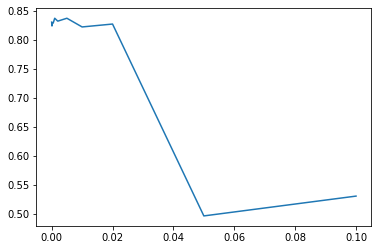

In [11]:
import numpy as np
import matplotlib.pyplot as plt
a = np.array(all_purs)
x = np.array(test_param)
plt.plot(x,a[29::30,1])

In [12]:
a[29::30,1]

array([0.83083333, 0.82416667, 0.82916667, 0.82916667, 0.8375    ,
       0.8325    , 0.8375    , 0.8225    , 0.8275    , 0.49666667,
       0.53083333])